问答模型

In [1]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
import torch
from torch import functional
from torch.utils.data import DataLoader, Dataset
# Load the tokenizer and model
from sacrebleu.metrics import BLEU

tokenizer = T5Tokenizer.from_pretrained("Langboat/mengzi-t5-base")
model = T5ForConditionalGeneration.from_pretrained("Langboat/mengzi-t5-base")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
batch_size = 8

d:\ProgramData\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. If you see this, DO NOT PANIC! This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [2]:
print(device)
model

cuda


T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseGatedActDense(
              (wi_0): Linear(in_features=768, out_features=2048, bias=False)
              (wi_1): Linear(in_features=768, out_features=2048, bias=False)
              (wo):

数据集处理

In [3]:
import json
class QADataSet(Dataset):
    def __init__(self, file_path):
        super().__init__()
        self.data_path = file_path
        self.data = self.load_data()
    
    def load_data(self):
        data = []
        with open(self.data_path, 'rt', encoding='utf-8') as f:
            for line in f:
                json_data = json.loads(line)
                question = json_data["question"]
                context = json_data["context"]
                data.append({
                    "input": f"问题是:{question},文章:{context}",
                    "answer": json_data["answer"]
                })
        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
    

In [4]:
from torch.utils.data import random_split
dataset = QADataSet('DuReaderQG/train.json')
train_dataset, valid_dataset = random_split(dataset, [int(len(dataset) * 0.8), len(dataset) - int(len(dataset) * 0.8)])
test_dataset = QADataSet('DuReaderQG/dev.json')
print(len(train_dataset), len(test_dataset))

11616 984


In [5]:
maxlength = 0
for data in train_dataset:
    inputs = tokenizer(data["input"],truncation=True, padding=True, max_length=10240, return_tensors="pt")
    maxlength = max(maxlength, inputs.input_ids.shape[1])
    inputs = tokenizer(data["answer"],truncation=True, padding=True, max_length=10240, return_tensors="pt")
    maxlength = max(maxlength, inputs.input_ids.shape[1])

for data in test_dataset:
    inputs = tokenizer(data["input"],truncation=True, padding=True, max_length=10240, return_tensors="pt")
    maxlength = max(maxlength, inputs.input_ids.shape[1])
    inputs = tokenizer(data["answer"],truncation=True, padding=True, max_length=10240, return_tensors="pt")
    maxlength = max(maxlength, inputs.input_ids.shape[1])
maxlength

1187

In [6]:
inputs = tokenizer(train_dataset[0]["input"], truncation=True, padding=True, max_length=1280, return_tensors="pt")
print(inputs)
print(tokenizer.convert_ids_to_tokens(inputs.input_ids[0]))

{'input_ids': tensor([[ 8080,    13,  2531,  1706, 19840,   619,  3706,  1257,     3,  1385,
            13,  4399,  2531, 11886,  5248,  2434,  6425,    22,  1537,     8,
          1302,  1501,   279,   533,  1266,  2434,  6425,    25,    86,  2758,
         10966,     5,  6997,   359,  1706,     5,  7547,     3,    20,  1312,
          3706,    26,  4734,   341,  7547,  1706,     5,  2926,     6,   179,
         10608,  2154,  4756,   201,   619,  3706,     3,  3706,   561,    18,
          2265,   880, 13357,  2056,   212,   742,   171,    22,   408,    64,
           715,   999, 24688,   120,  3184,   363,   511, 10615,  1780,  4577,
             4,     1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}
['问题是', ':', '南京', '车辆', 

In [7]:
def collate_fn(batch):
    inputs = []
    answers = []
    for b in batch:
        inputs.append(b["input"])
        answers.append(b["answer"])

    batch_data = tokenizer(inputs, truncation=True, padding=True, max_length=1280, return_tensors="pt")

    with tokenizer.as_target_tokenizer():
        answer_token = tokenizer(answers, truncation=True, padding=True, max_length=1280, return_tensors="pt").input_ids
        
        batch_data['decoder_input_ids'] = model.prepare_decoder_input_ids_from_labels(answer_token)
        eos_token_id = torch.where(answer_token == tokenizer.eos_token_id)[1]
        for idx, eos_id in enumerate(eos_token_id):
            answer_token[idx][eos_id + 1:] = -100  # Mask out the tokens after the EOS token
        batch_data['labels'] = answer_token
    
    return batch_data

In [8]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

In [9]:
batch = next(iter(train_loader))
print(batch.keys())
print('batch shape:', {k: v.shape for k, v in batch.items()})
print(batch['decoder_input_ids'][0])
print(batch['labels'][0])
print(batch['input_ids'][0])

dict_keys(['input_ids', 'attention_mask', 'decoder_input_ids', 'labels'])
batch shape: {'input_ids': torch.Size([8, 381]), 'attention_mask': torch.Size([8, 381]), 'decoder_input_ids': torch.Size([8, 7]), 'labels': torch.Size([8, 7])}
tensor([   0, 6347, 5503,    1,    0,    0,    0])
tensor([6347, 5503,    1, -100, -100, -100, -100])
tensor([ 8080,    13,  4748,   228, 21413,   456,     3,  1385,    13,   222,
         2689,   910,   303,  2944,    22, 26624,  2823,  2537,  2944,   196,
           25,  1366,     3,   111,  1503,  4339,    14,    93,   122,  1615,
         4657,     3,   894,    83,  1648,  4140,  7037,    10,     3,    97,
           84, 18516,  1363,   259,   141,  1397,   366,   228, 21413,     3,
           47, 10656,    24,  5260,   196,     3,    69,  2882,  7395,   458,
         1648,  4684,    22,    13, 28783,  1431, 28373,    25,  4684,     3,
          473,  2822,  2944,    30, 17694,  6347,  5503,     5,  2199,   125,
          209,  1802,   747,  4684,    2

d:\ProgramData\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:3660: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


训练

In [10]:
from tqdm.auto import tqdm
def train_loop(dataloader,model,optimizer,epoch, lr_scheduler,total_loss,device):
    progress_bar = tqdm(range(len(dataloader)))
    progress_bar.set_description(f'loss: {0:>7f}')
    finish_batch_num = (epoch-1) * len(dataloader)
    model.train()
    
    for batch, data in enumerate(dataloader,start=1):
        data = data.to(device)
        output = model(**data)
        loss = output.loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        total_loss += loss.item()
        progress_bar.set_description(f'loss: {total_loss / (finish_batch_num + batch):>7f}')
        progress_bar.update(1)
    
    return total_loss


In [11]:
# bleu1
blue_1 = BLEU(max_ngram_order=1)
blue_2 = BLEU(max_ngram_order=2)
blue_3 = BLEU(max_ngram_order=3)
blue_4 = BLEU()

In [12]:
blue_2

In [13]:
import numpy as np
def test_loop(dataloader,tokenizer,model,device):
    labels = []
    predictions = []
    model.eval()
    for batch, data in enumerate(dataloader):
        data = data.to(device)
        with torch.no_grad():
            output = model.generate(data["input_ids"],
                attention_mask=data["attention_mask"],
                max_length=1280,
                num_beams=4,
                no_repeat_ngram_size=2,
            )
        if isinstance(output, tuple):
            output = output[0]
        
        decoded_preds = tokenizer.batch_decode(output, skip_special_tokens=True)
        predictions += [' '.join(pred.strip()) for pred in decoded_preds]

        label_token = data["labels"].cpu().numpy()
        label_token = np.where(label_token == -100, tokenizer.pad_token_id, label_token)
        decoded_label = tokenizer.batch_decode(label_token, skip_special_tokens=True)

        labels += [' '.join(label.strip()) for label in decoded_label]
        print(f"batch: {batch}")
    
    bleu1 = blue_1.corpus_score(predictions, [labels]).score
    bleu2 = blue_2.corpus_score(predictions, [labels]).score
    bleu3 = blue_3.corpus_score(predictions, [labels]).score
    bleu4 = blue_4.corpus_score(predictions, [labels]).score
    print(f"BLEU-1: {bleu1:.2f}, BLEU-2: {bleu2:.2f}, BLEU-3: {bleu3:.2f}, BLEU-4: {bleu4:.2f}")
    return bleu1, bleu2, bleu3, bleu4



Epoch 0/10


  0%|          | 0/1452 [00:00<?, ?it/s]

d:\ProgramData\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:3660: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


batch: 0
batch: 1
batch: 2
batch: 3
batch: 4
batch: 5
batch: 6
batch: 7
batch: 8
batch: 9
batch: 10
batch: 11
batch: 12
batch: 13
batch: 14
batch: 15
batch: 16
batch: 17
batch: 18
batch: 19
batch: 20
batch: 21
batch: 22
batch: 23
batch: 24
batch: 25
batch: 26
batch: 27
batch: 28
batch: 29
batch: 30
batch: 31
batch: 32
batch: 33
batch: 34
batch: 35
batch: 36
batch: 37
batch: 38
batch: 39
batch: 40
batch: 41
batch: 42
batch: 43
batch: 44
batch: 45
batch: 46
batch: 47
batch: 48
batch: 49
batch: 50
batch: 51
batch: 52
batch: 53
batch: 54
batch: 55
batch: 56
batch: 57
batch: 58
batch: 59
batch: 60
batch: 61
batch: 62
batch: 63
batch: 64
batch: 65
batch: 66
batch: 67
batch: 68
batch: 69
batch: 70
batch: 71
batch: 72
batch: 73
batch: 74
batch: 75
batch: 76
batch: 77
batch: 78
batch: 79
batch: 80
batch: 81
batch: 82
batch: 83
batch: 84
batch: 85
batch: 86
batch: 87
batch: 88
batch: 89
batch: 90
batch: 91
batch: 92
batch: 93
batch: 94
batch: 95
batch: 96
batch: 97
batch: 98
batch: 99
batch: 100

  0%|          | 0/1452 [00:00<?, ?it/s]

d:\ProgramData\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:3660: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


batch: 0
batch: 1
batch: 2
batch: 3
batch: 4
batch: 5
batch: 6
batch: 7
batch: 8
batch: 9
batch: 10
batch: 11
batch: 12
batch: 13
batch: 14
batch: 15
batch: 16
batch: 17
batch: 18
batch: 19
batch: 20
batch: 21
batch: 22
batch: 23
batch: 24
batch: 25
batch: 26
batch: 27
batch: 28
batch: 29
batch: 30
batch: 31
batch: 32
batch: 33
batch: 34
batch: 35
batch: 36
batch: 37
batch: 38
batch: 39
batch: 40
batch: 41
batch: 42
batch: 43
batch: 44
batch: 45
batch: 46
batch: 47
batch: 48
batch: 49
batch: 50
batch: 51
batch: 52
batch: 53
batch: 54
batch: 55
batch: 56
batch: 57
batch: 58
batch: 59
batch: 60
batch: 61
batch: 62
batch: 63
batch: 64
batch: 65
batch: 66
batch: 67
batch: 68
batch: 69
batch: 70
batch: 71
batch: 72
batch: 73
batch: 74
batch: 75
batch: 76
batch: 77
batch: 78
batch: 79
batch: 80
batch: 81
batch: 82
batch: 83
batch: 84
batch: 85
batch: 86
batch: 87
batch: 88
batch: 89
batch: 90
batch: 91
batch: 92
batch: 93
batch: 94
batch: 95
batch: 96
batch: 97
batch: 98
batch: 99
batch: 100

  0%|          | 0/1452 [00:00<?, ?it/s]

d:\ProgramData\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:3660: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


batch: 0
batch: 1
batch: 2
batch: 3
batch: 4
batch: 5
batch: 6
batch: 7
batch: 8
batch: 9
batch: 10
batch: 11
batch: 12
batch: 13
batch: 14
batch: 15
batch: 16
batch: 17
batch: 18
batch: 19
batch: 20
batch: 21
batch: 22
batch: 23
batch: 24
batch: 25
batch: 26
batch: 27
batch: 28
batch: 29
batch: 30
batch: 31
batch: 32
batch: 33
batch: 34
batch: 35
batch: 36
batch: 37
batch: 38
batch: 39
batch: 40
batch: 41
batch: 42
batch: 43
batch: 44
batch: 45
batch: 46
batch: 47
batch: 48
batch: 49
batch: 50
batch: 51
batch: 52
batch: 53
batch: 54
batch: 55
batch: 56
batch: 57
batch: 58
batch: 59
batch: 60
batch: 61
batch: 62
batch: 63
batch: 64
batch: 65
batch: 66
batch: 67
batch: 68
batch: 69
batch: 70
batch: 71
batch: 72
batch: 73
batch: 74
batch: 75
batch: 76
batch: 77
batch: 78
batch: 79
batch: 80
batch: 81
batch: 82
batch: 83
batch: 84
batch: 85
batch: 86
batch: 87
batch: 88
batch: 89
batch: 90
batch: 91
batch: 92
batch: 93
batch: 94
batch: 95
batch: 96
batch: 97
batch: 98
batch: 99
batch: 100

  0%|          | 0/1452 [00:00<?, ?it/s]

batch: 0
batch: 1
batch: 2
batch: 3
batch: 4
batch: 5
batch: 6
batch: 7
batch: 8
batch: 9
batch: 10
batch: 11
batch: 12
batch: 13
batch: 14
batch: 15
batch: 16
batch: 17
batch: 18
batch: 19
batch: 20
batch: 21
batch: 22
batch: 23
batch: 24
batch: 25
batch: 26
batch: 27
batch: 28
batch: 29
batch: 30
batch: 31
batch: 32
batch: 33
batch: 34
batch: 35
batch: 36
batch: 37
batch: 38
batch: 39
batch: 40
batch: 41
batch: 42
batch: 43
batch: 44
batch: 45
batch: 46
batch: 47
batch: 48
batch: 49
batch: 50
batch: 51
batch: 52
batch: 53
batch: 54
batch: 55
batch: 56
batch: 57
batch: 58
batch: 59
batch: 60
batch: 61
batch: 62
batch: 63
batch: 64
batch: 65
batch: 66
batch: 67
batch: 68
batch: 69
batch: 70
batch: 71
batch: 72
batch: 73
batch: 74
batch: 75
batch: 76
batch: 77
batch: 78
batch: 79
batch: 80
batch: 81
batch: 82
batch: 83
batch: 84
batch: 85
batch: 86
batch: 87
batch: 88
batch: 89
batch: 90
batch: 91
batch: 92
batch: 93
batch: 94
batch: 95
batch: 96
batch: 97
batch: 98
batch: 99
batch: 100

  0%|          | 0/1452 [00:00<?, ?it/s]

d:\ProgramData\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:3660: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


batch: 0
batch: 1
batch: 2
batch: 3
batch: 4
batch: 5
batch: 6
batch: 7
batch: 8
batch: 9
batch: 10
batch: 11
batch: 12
batch: 13
batch: 14
batch: 15
batch: 16
batch: 17
batch: 18
batch: 19
batch: 20
batch: 21
batch: 22
batch: 23
batch: 24
batch: 25
batch: 26
batch: 27
batch: 28
batch: 29
batch: 30
batch: 31
batch: 32
batch: 33
batch: 34
batch: 35
batch: 36
batch: 37
batch: 38
batch: 39
batch: 40
batch: 41
batch: 42
batch: 43
batch: 44
batch: 45
batch: 46
batch: 47
batch: 48
batch: 49
batch: 50
batch: 51
batch: 52
batch: 53
batch: 54
batch: 55
batch: 56
batch: 57
batch: 58
batch: 59
batch: 60
batch: 61
batch: 62
batch: 63
batch: 64
batch: 65
batch: 66
batch: 67
batch: 68
batch: 69
batch: 70
batch: 71
batch: 72
batch: 73
batch: 74
batch: 75
batch: 76
batch: 77
batch: 78
batch: 79
batch: 80
batch: 81
batch: 82
batch: 83
batch: 84
batch: 85
batch: 86
batch: 87
batch: 88
batch: 89
batch: 90
batch: 91
batch: 92
batch: 93
batch: 94
batch: 95
batch: 96
batch: 97
batch: 98
batch: 99
batch: 100

  0%|          | 0/1452 [00:00<?, ?it/s]

batch: 0
batch: 1
batch: 2
batch: 3
batch: 4
batch: 5
batch: 6
batch: 7
batch: 8
batch: 9
batch: 10
batch: 11
batch: 12
batch: 13
batch: 14
batch: 15
batch: 16
batch: 17
batch: 18
batch: 19
batch: 20
batch: 21
batch: 22
batch: 23
batch: 24
batch: 25
batch: 26
batch: 27
batch: 28
batch: 29
batch: 30
batch: 31
batch: 32
batch: 33
batch: 34
batch: 35
batch: 36
batch: 37
batch: 38
batch: 39
batch: 40
batch: 41
batch: 42
batch: 43
batch: 44
batch: 45
batch: 46
batch: 47
batch: 48
batch: 49
batch: 50
batch: 51
batch: 52
batch: 53
batch: 54
batch: 55
batch: 56
batch: 57
batch: 58
batch: 59
batch: 60
batch: 61
batch: 62
batch: 63
batch: 64
batch: 65
batch: 66
batch: 67
batch: 68
batch: 69
batch: 70
batch: 71
batch: 72
batch: 73
batch: 74
batch: 75
batch: 76
batch: 77
batch: 78
batch: 79
batch: 80
batch: 81
batch: 82
batch: 83
batch: 84
batch: 85
batch: 86
batch: 87
batch: 88
batch: 89
batch: 90
batch: 91
batch: 92
batch: 93
batch: 94
batch: 95
batch: 96
batch: 97
batch: 98
batch: 99
batch: 100

  0%|          | 0/1452 [00:00<?, ?it/s]

batch: 0
batch: 1
batch: 2
batch: 3
batch: 4
batch: 5
batch: 6
batch: 7
batch: 8
batch: 9
batch: 10
batch: 11
batch: 12
batch: 13
batch: 14
batch: 15
batch: 16
batch: 17
batch: 18
batch: 19
batch: 20
batch: 21
batch: 22
batch: 23
batch: 24
batch: 25
batch: 26
batch: 27
batch: 28
batch: 29
batch: 30
batch: 31
batch: 32
batch: 33
batch: 34
batch: 35
batch: 36
batch: 37
batch: 38
batch: 39
batch: 40
batch: 41
batch: 42
batch: 43
batch: 44
batch: 45
batch: 46
batch: 47
batch: 48
batch: 49
batch: 50
batch: 51
batch: 52
batch: 53
batch: 54
batch: 55
batch: 56
batch: 57
batch: 58
batch: 59
batch: 60
batch: 61
batch: 62
batch: 63
batch: 64
batch: 65
batch: 66
batch: 67
batch: 68
batch: 69
batch: 70
batch: 71
batch: 72
batch: 73
batch: 74
batch: 75
batch: 76
batch: 77
batch: 78
batch: 79
batch: 80
batch: 81
batch: 82
batch: 83
batch: 84
batch: 85
batch: 86
batch: 87
batch: 88
batch: 89
batch: 90
batch: 91
batch: 92
batch: 93
batch: 94
batch: 95
batch: 96
batch: 97
batch: 98
batch: 99
batch: 100

  0%|          | 0/1452 [00:00<?, ?it/s]

batch: 0
batch: 1
batch: 2
batch: 3
batch: 4
batch: 5
batch: 6
batch: 7
batch: 8
batch: 9
batch: 10
batch: 11
batch: 12
batch: 13
batch: 14
batch: 15
batch: 16
batch: 17
batch: 18
batch: 19
batch: 20
batch: 21
batch: 22
batch: 23
batch: 24
batch: 25
batch: 26
batch: 27
batch: 28
batch: 29
batch: 30
batch: 31
batch: 32
batch: 33
batch: 34
batch: 35
batch: 36
batch: 37
batch: 38
batch: 39
batch: 40
batch: 41
batch: 42
batch: 43
batch: 44
batch: 45
batch: 46
batch: 47
batch: 48
batch: 49
batch: 50
batch: 51
batch: 52
batch: 53
batch: 54
batch: 55
batch: 56
batch: 57
batch: 58
batch: 59
batch: 60
batch: 61
batch: 62
batch: 63
batch: 64
batch: 65
batch: 66
batch: 67
batch: 68
batch: 69
batch: 70
batch: 71
batch: 72
batch: 73
batch: 74
batch: 75
batch: 76
batch: 77
batch: 78
batch: 79
batch: 80
batch: 81
batch: 82
batch: 83
batch: 84
batch: 85
batch: 86
batch: 87
batch: 88
batch: 89
batch: 90
batch: 91
batch: 92
batch: 93
batch: 94
batch: 95
batch: 96
batch: 97
batch: 98
batch: 99
batch: 100

  0%|          | 0/1452 [00:00<?, ?it/s]

d:\ProgramData\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:3660: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


batch: 0
batch: 1
batch: 2
batch: 3
batch: 4
batch: 5
batch: 6
batch: 7
batch: 8
batch: 9
batch: 10
batch: 11
batch: 12
batch: 13
batch: 14
batch: 15
batch: 16
batch: 17
batch: 18
batch: 19
batch: 20
batch: 21
batch: 22
batch: 23
batch: 24
batch: 25
batch: 26
batch: 27
batch: 28
batch: 29
batch: 30
batch: 31
batch: 32
batch: 33
batch: 34
batch: 35
batch: 36
batch: 37
batch: 38
batch: 39
batch: 40
batch: 41
batch: 42
batch: 43
batch: 44
batch: 45
batch: 46
batch: 47
batch: 48
batch: 49
batch: 50
batch: 51
batch: 52
batch: 53
batch: 54
batch: 55
batch: 56
batch: 57
batch: 58
batch: 59
batch: 60
batch: 61
batch: 62
batch: 63
batch: 64
batch: 65
batch: 66
batch: 67
batch: 68
batch: 69
batch: 70
batch: 71
batch: 72
batch: 73
batch: 74
batch: 75
batch: 76
batch: 77
batch: 78
batch: 79
batch: 80
batch: 81
batch: 82
batch: 83
batch: 84
batch: 85
batch: 86
batch: 87
batch: 88
batch: 89
batch: 90
batch: 91
batch: 92
batch: 93
batch: 94
batch: 95
batch: 96
batch: 97
batch: 98
batch: 99
batch: 100

  0%|          | 0/1452 [00:00<?, ?it/s]

d:\ProgramData\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:3660: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


batch: 0
batch: 1
batch: 2
batch: 3
batch: 4
batch: 5
batch: 6
batch: 7
batch: 8
batch: 9
batch: 10
batch: 11
batch: 12
batch: 13
batch: 14
batch: 15
batch: 16
batch: 17
batch: 18
batch: 19
batch: 20
batch: 21
batch: 22
batch: 23
batch: 24
batch: 25
batch: 26
batch: 27
batch: 28
batch: 29
batch: 30
batch: 31
batch: 32
batch: 33
batch: 34
batch: 35
batch: 36
batch: 37
batch: 38
batch: 39
batch: 40
batch: 41
batch: 42
batch: 43
batch: 44
batch: 45
batch: 46
batch: 47
batch: 48
batch: 49
batch: 50
batch: 51
batch: 52
batch: 53
batch: 54
batch: 55
batch: 56
batch: 57
batch: 58
batch: 59
batch: 60
batch: 61
batch: 62
batch: 63
batch: 64
batch: 65
batch: 66
batch: 67
batch: 68
batch: 69
batch: 70
batch: 71
batch: 72
batch: 73
batch: 74
batch: 75
batch: 76
batch: 77
batch: 78
batch: 79
batch: 80
batch: 81
batch: 82
batch: 83
batch: 84
batch: 85
batch: 86
batch: 87
batch: 88
batch: 89
batch: 90
batch: 91
batch: 92
batch: 93
batch: 94
batch: 95
batch: 96
batch: 97
batch: 98
batch: 99
batch: 100

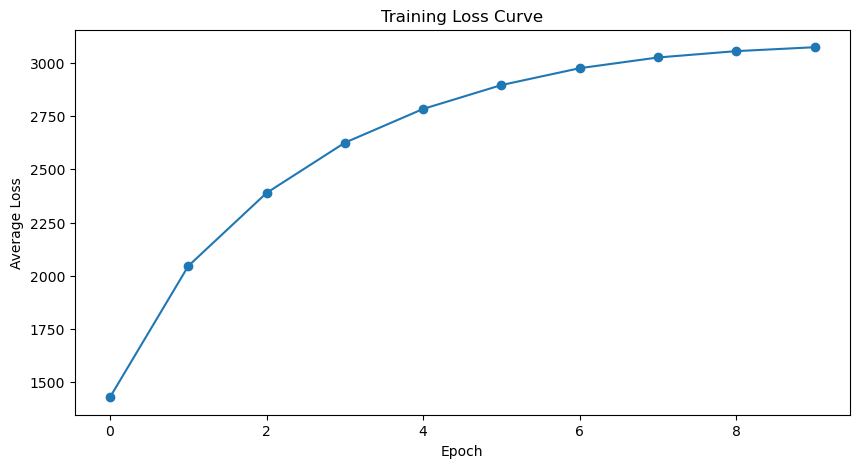

In [14]:
from matplotlib import pyplot as plt

lr = 1e-4
epochs = 10
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
from transformers import get_scheduler
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=len(train_loader) * epochs,
)
loss_history = []
total_loss = 0.0
maxbleusum = 0.0
for epoch in range(epochs):
    print(f"Epoch {epoch}/{epochs}")
    total_loss = train_loop(train_loader, model, optimizer, epoch + 1, lr_scheduler, total_loss, device)
    loss_history.append(total_loss)
    bleu1, bleu2, bleu3, bleu4 = test_loop(valid_loader, tokenizer, model, device)
    bleusum = (bleu1 + bleu2 + bleu3 + bleu4) / 4
    if bleusum > maxbleusum or epoch == 0:
        maxbleusum = bleusum
        model.save_pretrained(f"mengzi-t5-base-finetuned-epoch-{epoch}")
        print(f"Model saved at epoch {epoch} with BLEU sum: {bleusum:.2f}")

# 绘制 loss 曲线
plt.figure(figsize=(10, 5))
plt.plot(loss_history, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.title("Training Loss Curve")
plt.show()

测试

In [15]:
def test_loop_final(dataloader,tokenizer,model,device,save_path):
    labels = []
    predictions = []
    sources = []
    model.eval()
    for batch, data in enumerate(dataloader):
        data = data.to(device)
        with torch.no_grad():
            output = model.generate(data["input_ids"],
                attention_mask=data["attention_mask"],
                max_length=1280,
                num_beams=4,
                no_repeat_ngram_size=2,
            )
        if isinstance(output, tuple):
            output = output[0]
        
        decoded_sources = tokenizer.batch_decode(
            data["input_ids"].cpu().numpy(), 
            skip_special_tokens=True, 
            use_source_tokenizer=True
        )
        
        sources += [source.strip() for source in decoded_sources]

        decoded_preds = tokenizer.batch_decode(output, skip_special_tokens=True)
        predictions += [' '.join(pred.strip()) for pred in decoded_preds]

        label_token = data["labels"].cpu().numpy()
        label_token = np.where(label_token == -100, tokenizer.pad_token_id, label_token)
        decoded_label = tokenizer.batch_decode(label_token, skip_special_tokens=True)

        labels += [' '.join(label.strip()) for label in decoded_label]
        print(f"batch: {batch}")
    
    bleu1 = blue_1.corpus_score(predictions, [labels]).score
    bleu2 = blue_2.corpus_score(predictions, [labels]).score
    bleu3 = blue_3.corpus_score(predictions, [labels]).score
    bleu4 = blue_4.corpus_score(predictions, [labels]).score
    print(f"BLEU-1: {bleu1:.2f}, BLEU-2: {bleu2:.2f}, BLEU-3: {bleu3:.2f}, BLEU-4: {bleu4:.2f}")
    results = []
    for source, pred, label in zip(sources, predictions, labels):
        results.append({
            "context": source, 
            "prediction": pred, 
            "labels": label
        })
    with open(save_path, 'w', encoding='utf-8') as f:
        for result in results:
            f.write(json.dumps(result, ensure_ascii=False) + '\n')
    return bleu1, bleu2, bleu3, bleu4


In [16]:

bleu1, bleu2, bleu3, bleu4 = test_loop_final(test_loader, tokenizer, model, device, "test_predictions.json")
print(f"Test BLEU-1: {bleu1:.2f}, BLEU-2: {bleu2:.2f}, BLEU-3: {bleu3:.2f}, BLEU-4: {bleu4:.2f}")


d:\ProgramData\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:3660: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


batch: 0
batch: 1
batch: 2
batch: 3
batch: 4
batch: 5
batch: 6
batch: 7
batch: 8
batch: 9
batch: 10
batch: 11
batch: 12
batch: 13
batch: 14
batch: 15
batch: 16
batch: 17
batch: 18
batch: 19
batch: 20
batch: 21
batch: 22
batch: 23
batch: 24
batch: 25
batch: 26
batch: 27
batch: 28
batch: 29
batch: 30
batch: 31
batch: 32
batch: 33
batch: 34
batch: 35
batch: 36
batch: 37
batch: 38
batch: 39
batch: 40
batch: 41
batch: 42
batch: 43
batch: 44
batch: 45
batch: 46
batch: 47
batch: 48
batch: 49
batch: 50
batch: 51
batch: 52
batch: 53
batch: 54
batch: 55
batch: 56
batch: 57
batch: 58
batch: 59
batch: 60
batch: 61
batch: 62
batch: 63
batch: 64
batch: 65
batch: 66
batch: 67
batch: 68
batch: 69
batch: 70
batch: 71
batch: 72
batch: 73
batch: 74
batch: 75
batch: 76
batch: 77
batch: 78
batch: 79
batch: 80
batch: 81
batch: 82
batch: 83
batch: 84
batch: 85
batch: 86
batch: 87
batch: 88
batch: 89
batch: 90
batch: 91
batch: 92
batch: 93
batch: 94
batch: 95
batch: 96
batch: 97
batch: 98
batch: 99
batch: 100

In [21]:
print(loss_history)
new_loss_history = [loss / (len(train_loader) * (batch + 1)) for batch,loss in enumerate(loss_history)]
new_loss_history

[1429.7221645340323, 2045.920828225091, 2389.282426374033, 2625.164786267793, 2783.793452767073, 2895.9623683262034, 2975.176391485613, 3025.450637957838, 3055.336035664339, 3073.6578297904925]


[0.9846571381088377,
 0.7045181915375658,
 0.5485037709765916,
 0.45199118220864204,
 0.3834426243480817,
 0.3324107401660013,
 0.29271707905210675,
 0.26045546125670094,
 0.2338028799865579,
 0.21168442353929012]

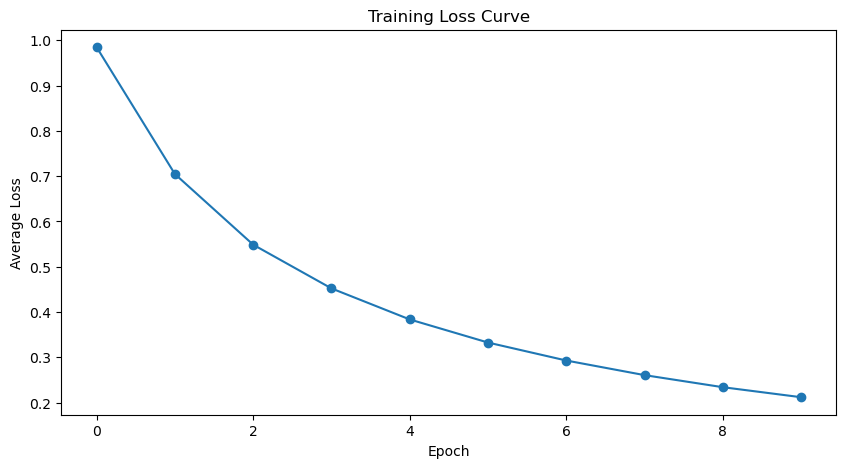

In [23]:

# 绘制 loss 曲线
plt.figure(figsize=(10, 5))
plt.plot(new_loss_history, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.title("Training Loss Curve")
plt.show()